# Dimensionality reduction on neural data

### Table of contents

1. [**Loading of a model and dataset**](#loading)
2. [**Assessing goodness-of-fit**](#assess)
3. [**Computing spike count distributions**](#SCD)
4. [**Inspecting model parameters**](#inspect)


In [147]:
### imports ###
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt

#plt.style.use(['paper.mplstyle'])

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.12.1+cpu
Using device: cpu


## Load model and dataset <a class="anchor" id="loading"></a>

In [148]:
checkpoint_dir = './'
session_id = '12-120806'
phase = 'wake'

single_spikes = False
dt = 0.001

ll_mode = 'Uqd3'  # stands for universal count model with exponential-quadratic expansion and C = 3
filt_mode = ''
map_mode = 'svgp64'  # a sparse variational GP mapping with 64 inducing points
x_mode = 'hd-w-s-pos-t'  # observed covariates (behaviour)
z_mode = ''  # latent covariates
hist_len = 0
folds = 5  # cross-validation folds
delays = [0]
model_info = (ll_mode, filt_mode, map_mode, x_mode, z_mode, hist_len, folds, delays)

In [149]:
checkpoint_dir = '../example/'

bin_size = 50  # ms
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 5000  # size of time segments of each batch in dataset below


# data
dataset_tuple = HDC.get_dataset(session_id, phase, bin_size, single_spikes, path='../data/')

# model and train/test split based on which validation fold is given by cv_run
modelfit, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, model_info, dataset_tuple, HDC.inputs_used, HDC.enc_used,
    delay, cv_run, batch_size, gpu_dev, tensor_type=torch.float, jitter=1e-5
)

## Compute spike count distributions and tuning curves

In [150]:
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, data_name = dataset_tuple

hd_sweep = torch.linspace(0, 2 * np.pi, 100)

covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean() * torch.ones((100, 1)) for k in range(1, len(rcov))],
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

P_list = []

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(units_used)), MC=30,
        trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

In [151]:
lower, mean, upper = utils.signal.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95])


K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

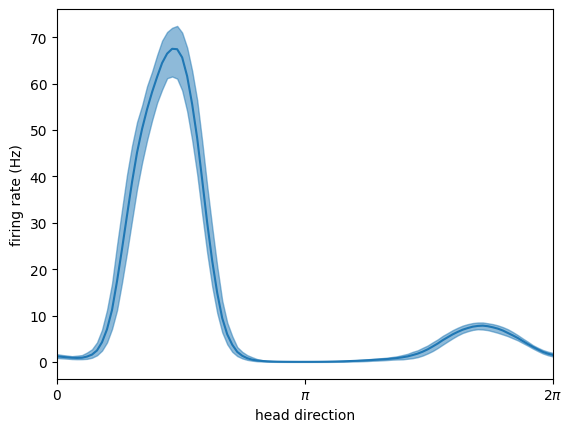

In [152]:
fig, ax = plt.subplots()

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 16  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(),
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('firing rate (Hz)')
ax.set_xlabel('head direction')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()

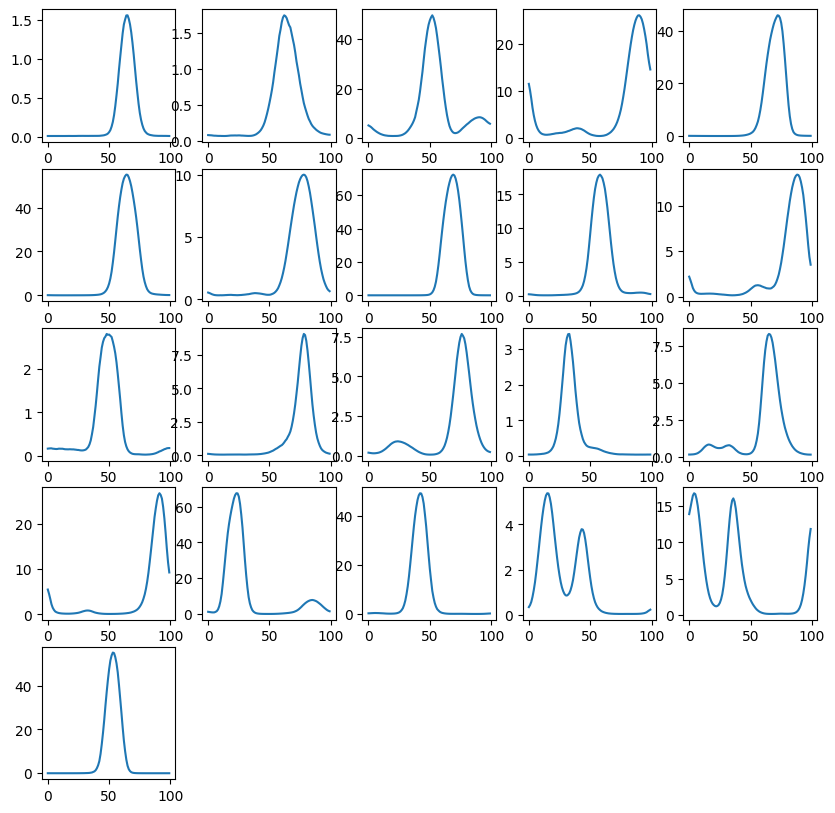

In [153]:
plt.figure(figsize=(10, 10))

for i in range(mean.shape[0]):
    plt.subplot(5, 5, i+1)
    plt.plot(mean[i])

plt.show()

## PCA on head direction tuning curves

[4.16760373e-01 2.34049431e-01 1.75823286e-01 7.97155931e-02
 5.84498445e-02 1.98650859e-02 1.13532998e-02 2.16799624e-03
 8.65970508e-04 4.29571670e-04 2.87677890e-04 1.31963475e-04
 4.11979806e-05 3.35075897e-05 1.48921230e-05 9.02503524e-06
 8.68705152e-07 3.46282466e-07 6.16254519e-08 8.03409485e-09
 2.45913093e-33]
0.8266330896000613


<BarContainer object of 21 artists>

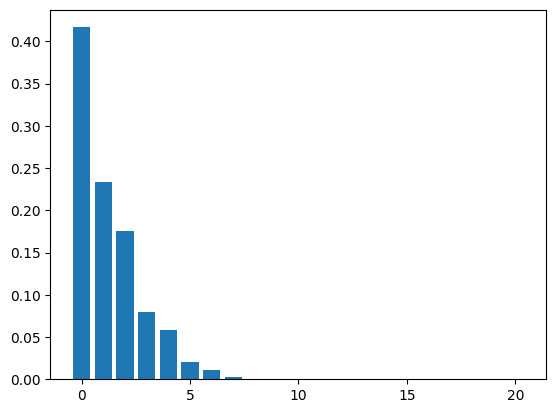

In [154]:
from sklearn.decomposition import PCA
# mean is a matrix [N, T] with N neurons and T samples from tuning curve

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])

pca = PCA()
pca.fit_transform(mean)
var_explained = pca.explained_variance_ratio_
print(var_explained)
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)

(21, 3)


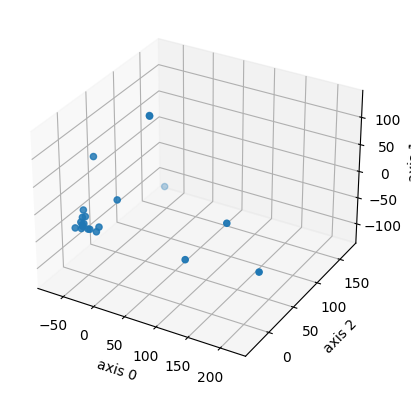

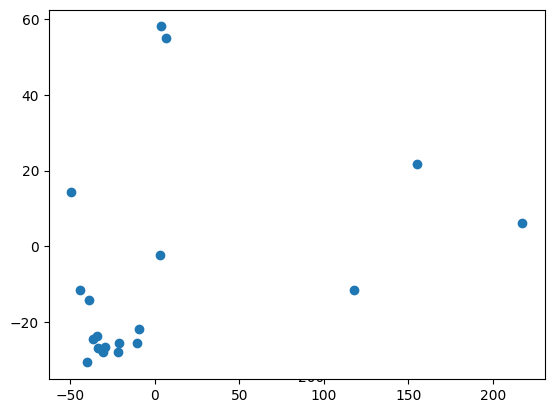

In [156]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(mean)

index = np.where(np.array(principal_components[:,2]) > 150)
print(principal_components.shape)
components = np.delete(principal_components, obj=index, axis=0)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(principal_components[:,0], principal_components[:, 2], principal_components[:, 1])
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 2')
ax.set_zlabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(components[:,0], components[:, 2], components[:, 1])
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 2')
ax.set_zlabel('axis 1')

ax = fig.add_subplot()
ax.scatter(components[:, 0], components[:, 2])

[5.37778496e-01 1.68729094e-01 1.29382449e-01 7.37272077e-02
 5.46250138e-02 2.14416501e-02 1.03788641e-02 2.37996607e-03
 6.64286026e-04 4.02703266e-04 2.74113274e-04 1.20958734e-04
 3.40329321e-05 2.85660143e-05 1.78073468e-05 1.25374913e-05
 1.02118642e-06 9.11413841e-07 2.89678873e-07 3.17184912e-08
 1.43909348e-32]
0.8358900391186884


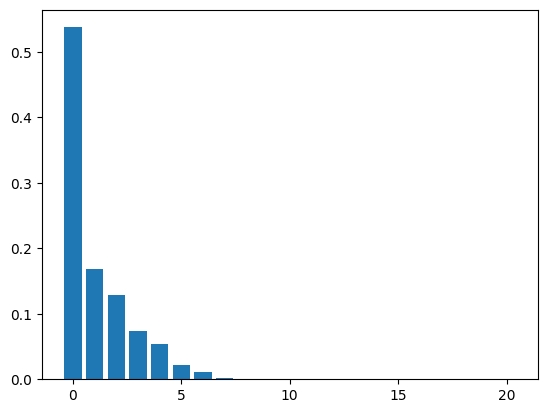

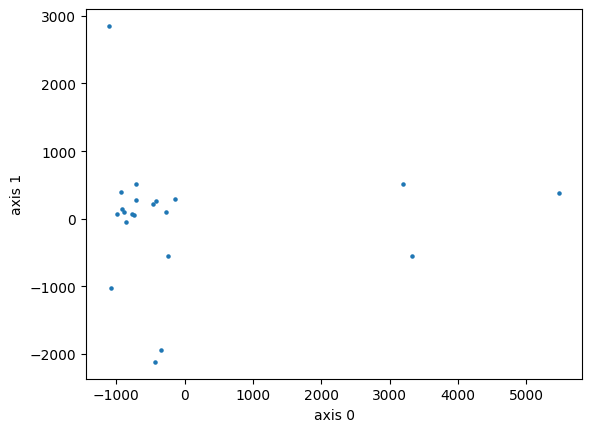

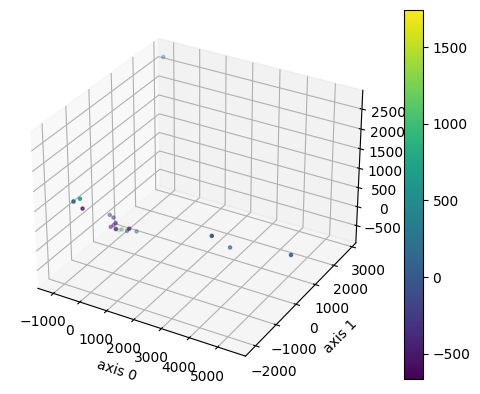

In [237]:
%matplotlib inline

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate.float(), [0.05, 0.5, 0.95])

pca = PCA()
pca.fit(mean)
var_explained = pca.explained_variance_ratio_
print(var_explained)
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)

components = pca.transform(mean)

fig, ax = plt.subplots()

ax.scatter(components[:, 0], components[:, 1], s=5)
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=components[:, 3], cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
fig.colorbar(p)

## PCA on time series SCDs of HD cells

In [243]:
hd_trajectory = torch.tensor(rcov[0])
num_samples = list(hd_trajectory.size())[0]
print('num of time samples ', num_samples)
covariates = torch.cat([
    hd_trajectory[:, None],  # sweep over head direction
    *[rcov[k].mean() * torch.ones((num_samples, 1)) for k in range(1, len(rcov))],
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

num of time samples  43776


In [244]:

# split into chunks of 4000 datapoints
chunk_size = 4000
chunk_num = int(np.ceil(num_samples / chunk_size))
P_mc = None
for i in range(chunk_num):
    print('batch ', i)
    with torch.no_grad():
        P_mc_chunk = lib.helper.compute_P(
            modelfit, covariates[:,:,i*chunk_size:(i+1)*chunk_size, :], list(range(units_used)), MC=30,
            trials=1)  # predictive posterior
    P_mc_chunk = P_mc_chunk.cpu()  # count probabilities of shape (MC, neurons, steps, count)
    if P_mc is None:
        P_mc = P_mc_chunk
    else:
        P_mc = np.concatenate((P_mc, P_mc_chunk), axis=2)

batch  0
batch  1
batch  2
batch  3
batch  4
batch  5
batch  6
batch  7
batch  8
batch  9
batch  10


In [245]:
print(P_mc.shape)
print(chunk_num)

(30, 21, 43776, 11)
11


In [ ]:
K = P_mc.shape[-1]
counts = torch.arange(K)
hd_mean = (counts[None, None, None, :] * P_mc.astype(float)).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz

_, mean, _ = utils.signal.percentiles_from_samples(hd_rate.float(), [0.05, 0.5, 0.95])

print(mean.shape)

[5.59108690e-01 1.92549568e-01 1.22114674e-01 6.90318472e-02
 2.94652188e-02 2.17428244e-02 3.60402810e-03 9.66623385e-04
 6.23095150e-04 3.98322030e-04 2.17455808e-04 8.86476514e-05
 3.66588115e-05 2.12399923e-05 1.58073976e-05 1.29267344e-05
 1.20374146e-06 6.78527837e-07 4.07591622e-07 5.45747517e-08
 2.89843451e-08]
0.8737729311452346


<BarContainer object of 21 artists>

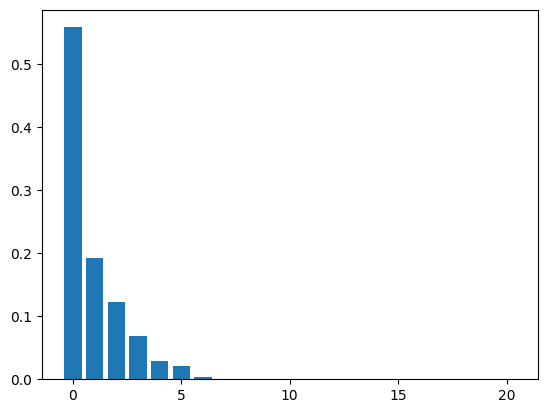

In [192]:
pca = PCA()
activity = torch.transpose(mean, 0, 1)

pca.fit(activity)
var_explained = pca.explained_variance_ratio_
print(var_explained)
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)

In [242]:
%matplotlib qt

components = pca.transform(activity)
print(components.shape)

fig, ax = plt.subplots()

ax.scatter(components[:, 0], components[:, 1], s=5)
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=np.arange(components.shape[0]), cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows time.')
fig.colorbar(p)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=components[:, 2], cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows z axis.')
fig.colorbar(p)


(43776, 21)


## PCA for Fano Factor

In [221]:
%matplotlib inline

In [238]:
K = P_mc.shape[-1]
counts = torch.arange(K)
hd_mean = (counts[None, None, None, :] * P_mc.astype(float)).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz
hd_var = ((counts[None, None, None, :] - hd_mean[:,:,:,None])**2 * P_mc).sum(-1)
hd_FF = hd_var / (hd_mean + 1e-12)
_, mean, _ = utils.signal.percentiles_from_samples(hd_FF.float(), [0.05, 0.5, 0.95])

print(mean.shape)

torch.Size([21, 43776])


[2.74690832e-01 2.52676004e-01 2.32137935e-01 1.22788723e-01
 5.87572346e-02 2.45951591e-02 1.24961993e-02 1.15817150e-02
 5.21620754e-03 2.02324558e-03 1.16529685e-03 8.49921380e-04
 4.56526501e-04 2.63431006e-04 1.79477438e-04 6.83985859e-05
 2.97285352e-05 1.02118568e-05 6.46127598e-06 4.45529301e-06
 2.83595612e-06]
0.7595047709191476


<BarContainer object of 21 artists>

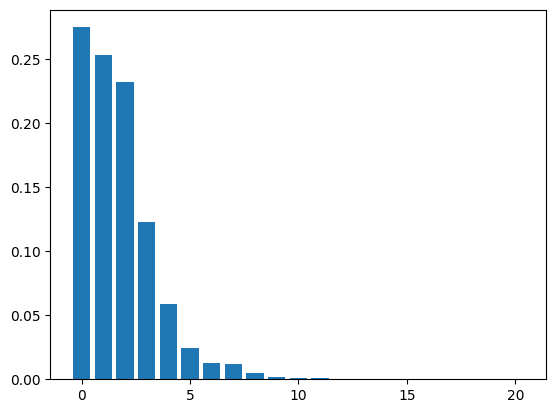

In [239]:
pca = PCA()
activity = torch.transpose(mean, 0, 1)

pca.fit(activity)
var_explained = pca.explained_variance_ratio_
print(var_explained)
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)

(43776, 21)


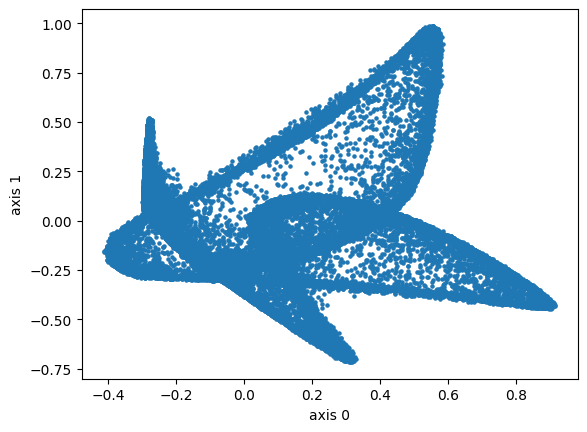

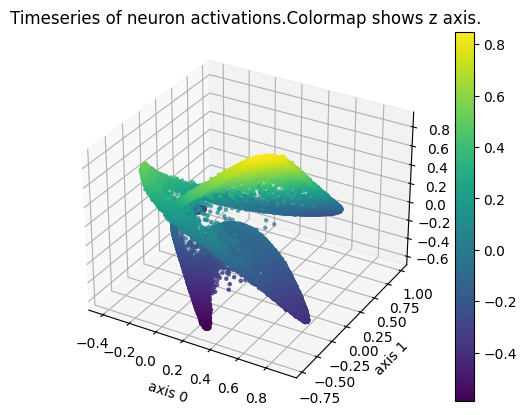

In [241]:
%matplotlib inline
components = pca.transform(activity)
print(components.shape)

fig, ax = plt.subplots()

ax.scatter(components[:, 0], components[:, 1], s=5)
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=components[:, 2], cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows z axis.')
fig.colorbar(p)


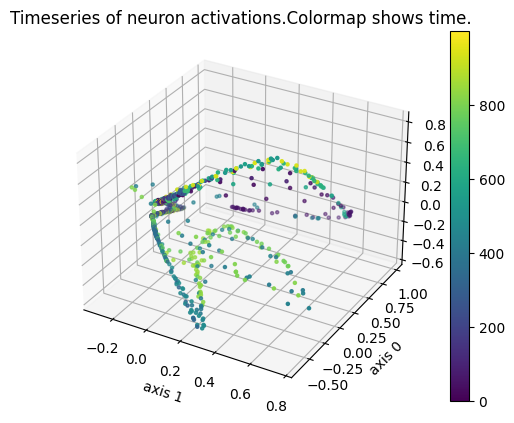

In [225]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
components_part = components[39000:40000, :]
p = ax.scatter(components_part[:,0], components_part[:, 1], components_part[:, 2], s=5, c=np.arange(components_part.shape[0]), cmap='viridis')
ax.set_xlabel('axis 1')
ax.set_ylabel('axis 0')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows time.')
fig.colorbar(p)


## PCA for skewness and kurtosis factors

In [197]:
K = P_mc.shape[-1]
counts = torch.arange(K)
hd_mean = (counts[None, None, None, :] * P_mc.astype(float)).sum(-1)  # (MC, neurons, steps)
hd_var = ((counts[None, None, None, :] - hd_mean[:,:,:,None])**2 * P_mc).sum(-1)
hd_third_moment = ((counts[None, None, None, :] - hd_mean[:,:,:,None])**3 * P_mc).sum(-1)
hd_SF = hd_third_moment / (hd_mean + 1e-12) # skewness factor
_, mean, _ = utils.signal.percentiles_from_samples(hd_SF.float(), [0.05, 0.5, 0.95])


print(mean.shape)

torch.Size([21, 43776])


0.8139954505053061


<BarContainer object of 21 artists>

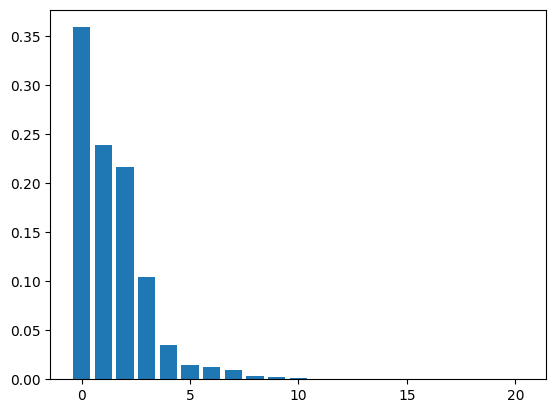

In [198]:
pca = PCA()
activity = torch.transpose(mean, 0, 1)

pca.fit(activity)
var_explained = pca.explained_variance_ratio_
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)

(43776, 21)


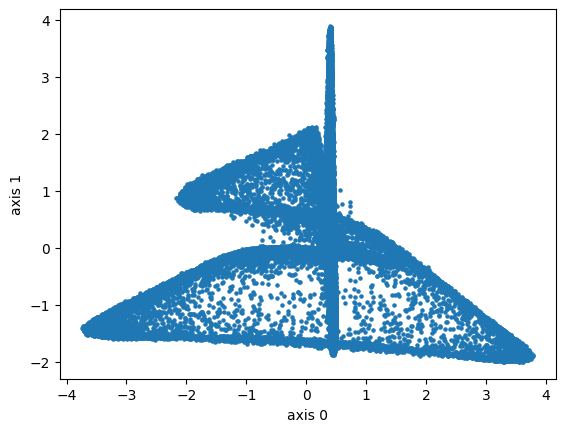

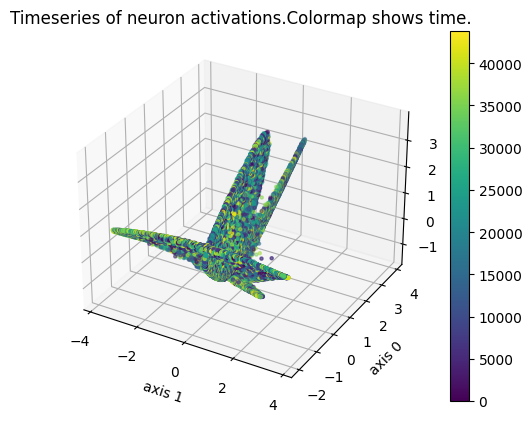

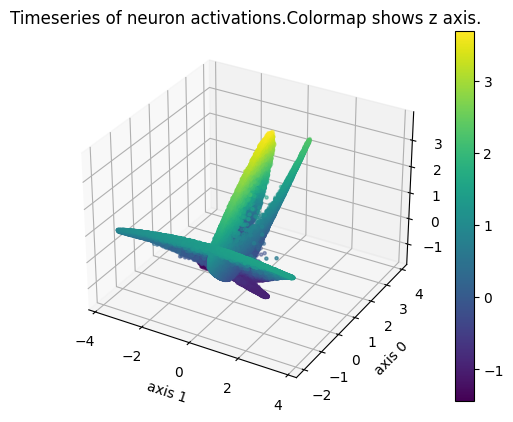

In [199]:
%matplotlib inline
components = pca.transform(activity)
print(components.shape)

fig, ax = plt.subplots()

ax.scatter(components[:, 0], components[:, 1], s=5)
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=np.arange(components.shape[0]), cmap='viridis')
ax.set_xlabel('axis 1')
ax.set_ylabel('axis 0')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows time.')
fig.colorbar(p)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=components[:, 2], cmap='viridis')
ax.set_xlabel('axis 1')
ax.set_ylabel('axis 0')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows z axis.')
fig.colorbar(p)

In [200]:
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=components[:, 2], cmap='viridis')
ax.set_xlabel('axis 1')
ax.set_ylabel('axis 0')
ax.set_zlabel('axis 2')
fig.colorbar(p)

## Animated plot of neuron activation time series

torch.Size([21, 43776])
[5.59108690e-01 1.92549568e-01 1.22114674e-01 6.90318472e-02
 2.94652188e-02 2.17428244e-02 3.60402810e-03 9.66623385e-04
 6.23095150e-04 3.98322030e-04 2.17455808e-04 8.86476514e-05
 3.66588115e-05 2.12399923e-05 1.58073976e-05 1.29267344e-05
 1.20374146e-06 6.78527837e-07 4.07591622e-07 5.45747517e-08
 2.89843451e-08]
0.8737729311452346
(43776, 21)


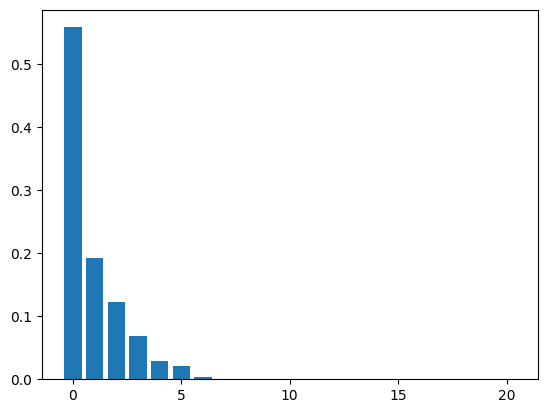

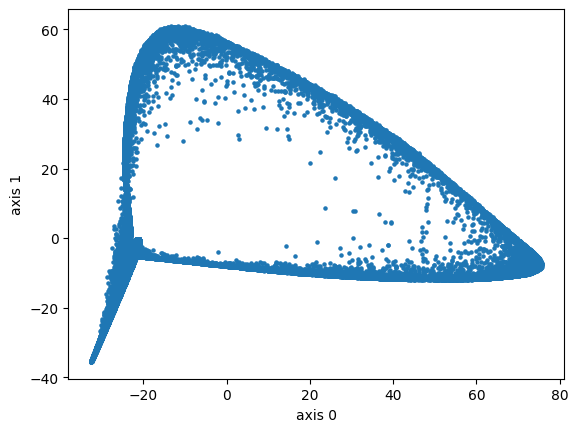

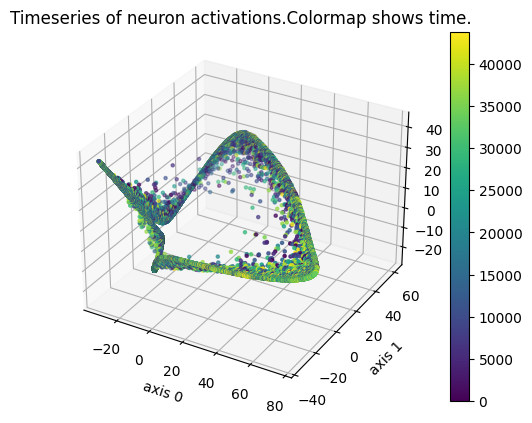

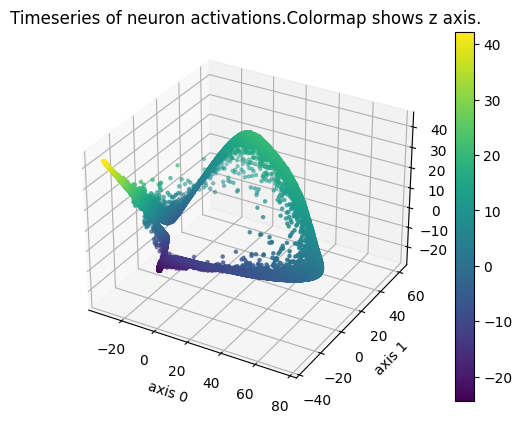

In [226]:
K = P_mc.shape[-1]
counts = torch.arange(K)
hd_mean = (counts[None, None, None, :] * P_mc.astype(float)).sum(
    -1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz

_, mean, _ = utils.signal.percentiles_from_samples(hd_rate.float(),
                                                   [0.05, 0.5, 0.95])

print(mean.shape)
pca = PCA()
activity = torch.transpose(mean, 0, 1)

pca.fit(activity)
var_explained = pca.explained_variance_ratio_
print(var_explained)
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)
components = pca.transform(activity)
print(components.shape)

fig, ax = plt.subplots()

ax.scatter(components[:, 0], components[:, 1], s=5)
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:, 0], components[:, 1], components[:, 2], s=5,
               c=np.arange(components.shape[0]), cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows time.')
fig.colorbar(p)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:, 0], components[:, 1], components[:, 2], s=5,
               c=components[:, 2], cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows z axis.')
fig.colorbar(p)

In [230]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation

datapoints = []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def animate(i, datapoints):
    if i == 0:
        datapoints = components[i, :]
    else:
        np.append(datapoints, components[i, :], axis=1)
    p = ax.scatter(datapoints[:, 0], datapoints[:, 1], datapoints[:, 2], s=5,
               c=np.arange(datapoints.shape[0]), cmap='viridis')

    return p


ani = FuncAnimation(fig, animate, frames=200, interval=50, repeat=False, fargs=(datapoints))
plt.show()

In [232]:

x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)


fig, ax = plt.subplots()
line, = ax.plot([])     # A tuple unpacking to unpack the only plot
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.1, 1.1)

def animate(frame_num):
    y = np.sin(x + 2*np.pi * frame_num/100)
    line.set_data((x, y))
    return line

anim = FuncAnimation(fig, animate, frames=100, interval=20)
plt.show()